In [1]:
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
FILE_PATH = r"falcon_indoor_flight_1_data.h5"
cv2.ocl.setUseOpenCL(True)

In [2]:
with h5py.File(FILE_PATH, "r") as file:
    w, h = list(file["prophesee"]["left"]["calib"]["resolution"])
    distortion_coeffs_left = list(file["prophesee"]["left"]["calib"]["distortion_coeffs"])
    fx, fy, cx, cy = (list(file["prophesee"]["left"]["calib"]["intrinsics"]))
    K_left = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    distortion_coeffs_right = list(file["prophesee"]["right"]["calib"]["distortion_coeffs"])
    fx, fy, cx, cy = (list(file["prophesee"]["right"]["calib"]["intrinsics"]))
    K_right = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    

    distortion_coeffs_rgb = (list(file["ovc"]["rgb"]["calib"]["distortion_coeffs"]))
    fx, fy, cx, cy = list(file["ovc"]["rgb"]["calib"]["intrinsics"])
    K_rgb = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

In [3]:
def event_generator(file_path, cam_direction="left", batch_size=1024):
    with h5py.File(file_path, "r") as file:
        x = file["prophesee"][cam_direction]["x"]
        y = file["prophesee"][cam_direction]["y"]
        p = file["prophesee"][cam_direction]["p"]
        t = file["prophesee"][cam_direction]["t"]
        total = x.shape[0]
        for i in range(0, total, batch_size):
            yield (
                x[i : i + batch_size],
                y[i : i + batch_size],
                p[i : i + batch_size],
                t[i : i + batch_size],
            )

In [4]:
def event_frame(coords, polarities, img_shape):
    matrix = np.ones(img_shape, dtype=np.uint8) * 127
    coords = np.array(coords)
    if len(coords) > 0:
        y = coords[:, 0]
        x = coords[:, 1]
        matrix[y, x] = np.where(np.array(polarities) > 0, 255, 0)
    return matrix

In [5]:
class Odometry:
    def __init__(self):
        self.cur_R = np.eye(3)
        self.cur_t = np.zeros((3, 1))
        self.trajectory_3d = []

        self.fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
        self.brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        self.bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        self.prev_img = None

    def odom(self, picture, K) -> None:
        if len(picture.shape) == 3:
            gray = cv2.cvtColor(picture, cv2.COLOR_BGR2GRAY)
        else:
            gray = picture.copy()

        gray = cv2.UMat(gray)
        if self.prev_img is None:
            self.prev_img = gray
            return 

        kp1 = self.fast.detect(self.prev_img, None)
        kp2 = self.fast.detect(gray, None)
        if len(kp1) < 10 or len(kp2) < 10:
            self.prev_img = gray
            return 

        kp1, des1 = self.brief.compute(self.prev_img, kp1)
        kp2, des2 = self.brief.compute(gray, kp2)
        if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
            self.prev_img = gray
            return 

        matches = self.bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)

        if len(matches) < 8:
            self.prev_img = gray
            return 

        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        E, mask = cv2.findEssentialMat(
            pts2, pts1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
        )
        if E is None:
            self.prev_img = gray
            return 

        _, R, t, mask_pose = cv2.recoverPose(E, pts2, pts1, K)

        self.cur_t += self.cur_R @ t
        self.cur_R = R @ self.cur_R

        self.trajectory_3d.append(self.cur_t.flatten())

        self.prev_img = gray
        return 

In [6]:
cnt = 1
batch_idx = 0
temp_x, temp_y, temp_p, temp_t = [], [], [], []
exit = False

odometry = Odometry()

for x_batch, y_batch, p_batch, t_batch in event_generator(
    FILE_PATH, "left", batch_size=10000
):
    batch_idx += 1
    if batch_idx % 25 != 0:
        continue

    temp_x.extend(x_batch)
    temp_y.extend(y_batch)
    temp_p.extend(np.where(p_batch > 0, 1, -1))
    temp_t.extend(t_batch)

    while len(temp_t) > 0 and temp_t[-1] > cnt * 1e5:
        cnt += 1
        coords = list(zip(temp_y, temp_x))
        img = event_frame(coords, temp_p, (h, w))
        odometry.odom(img, K_left)
        cv2.imshow("Event Frame", img)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            exit = True
            break
        temp_x.clear()
        temp_y.clear()
        temp_p.clear()
        temp_t.clear()
    if exit:
        break

cv2.destroyAllWindows()

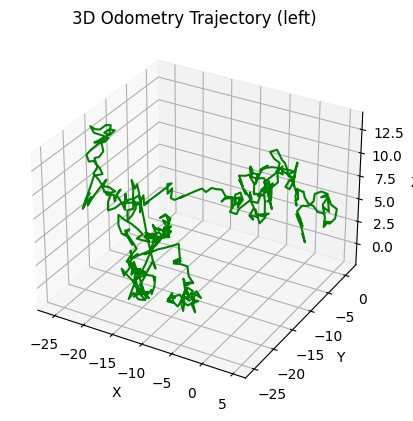

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

if len(odometry.trajectory_3d) > 0:

    trajectory_3d_np = np.array(odometry.trajectory_3d)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(
        trajectory_3d_np[:, 0],
        trajectory_3d_np[:, 1],
        trajectory_3d_np[:, 2],
        color="g",
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Odometry Trajectory (left)")
    plt.show()

In [8]:
odometry = Odometry()

with h5py.File(FILE_PATH, "r") as file:
    rgb_dataset = file["ovc"]["rgb"]["data"]
    num_images = rgb_dataset.shape[0]
    for i in range(num_images):
        rgb = rgb_dataset[i]
        rgb = np.array(rgb, dtype=np.uint8)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        odometry.odom(gray, K_rgb)
        cv2.imshow("Grayscale OVC Image", gray)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

cv2.destroyAllWindows()

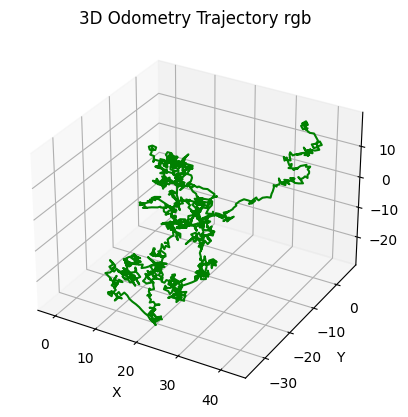

In [9]:
if len(odometry.trajectory_3d) > 0:
    trajectory_3d_np = np.array(odometry.trajectory_3d)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(
        trajectory_3d_np[:, 0],
        trajectory_3d_np[:, 1],
        trajectory_3d_np[:, 2],
        color="g",
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Odometry Trajectory rgb")
    plt.show()